In [1]:
# Unconditioned

In [2]:
# %pip install -q diffusers

In [9]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torchvision.transforms as transforms

from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

from tqdm.auto import tqdm
import os
import pandas as pd
import numpy as np


device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


## 加载数据

In [10]:
# 检查一个图片格式
img_path = "Dfinetune/test/HF_Sava_000468a_20220614_60x.x_9438.y_38379.png"
# 打开图片
img = Image.open(img_path)
print("分辨率:", img.size)  # (宽, 高)
print("色彩:", img.mode)   # RGB or L(灰度)

分辨率: (186, 126)
色彩: L


In [11]:
class DiatomDataset(Dataset):
    def __init__(self, split_csv, label_csv, root_dir, transform=None):
        """
        Args:
            split_csv (str): train.csv/test.csv 路径
            label_csv (str): label.csv 路径
            root_dir (str): 图片所在文件夹路径 (train/ 或 test/)
            transform (callable, optional): 图像转换pipeline
        """
        # 加载文件名列表
        self.file_list = pd.read_csv(split_csv, header=None, names=['filename'])
        
        # 加载标签映射
        label_df = pd.read_csv(label_csv, sep=",", header=None, names=["filename", "label"])
        self.label_map = dict(zip(label_df.filename, label_df.label))
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # 获取文件名和标签
        img_name = self.file_list.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name)
        # 加载图像
        image = Image.open(img_path)
        # 类型转换(暂时不需要)
        # image = Image.open(img_path).convert("L")  # 彩色图.convert("RGB")
        
        # 查找标签
        if img_name not in self.label_map:
            raise ValueError(f"找不到标签: {img_name} 在 labels.csv")
        label = int(self.label_map[img_name])
        
        # 预处理
        if self.transform:
            image = self.transform(image)
        elif self.transform1:
            image = self.transform1(image)
        elif self.transform2:
            image = self.transform2(image)
        return image, label


In [12]:
# 图像处理pipeline
# 1.简单缩放
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),  # rgb
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 2.padding
transform1 = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.Pad(padding=(0, (128 - img.size[1]) // 2)),  # 高度补齐
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 3.裁剪缩放
transform2 = transforms.Compose([
    transforms.Lambda(lambda img: transforms.CenterCrop(min(img.size))(img)),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 路径变量
train_csv = "Dfinetune/train.csv"
test_csv  = "Dfinetune/test.csv"
label_csv = "Dfinetune/labels.csv"
train_root = "Dfinetune/train"
test_root  = "Dfinetune/test"

# 数据集和加载器
train_set = DiatomDataset(train_csv, label_csv, train_root, transform=transform2)
test_set  = DiatomDataset(test_csv,  label_csv, test_root,  transform=transform2)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=8, shuffle=False)


Batch shape: torch.Size([8, 1, 64, 64])
Labels: tensor([26, 18, 30, 12, 34, 17,  2,  7])


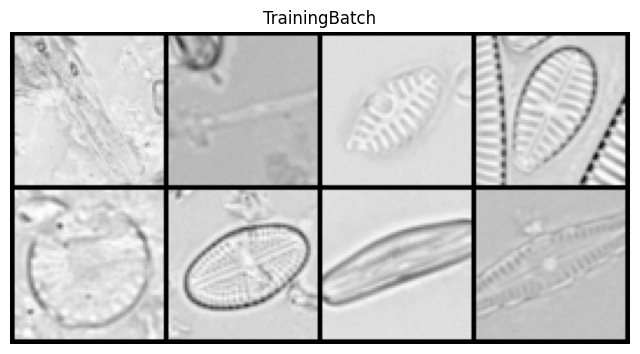

In [13]:
# 获取一个 batch, 验证加载
x, y = next(iter(train_loader))
print("Batch shape:", x.shape)
print("Labels:", y)

# 可视化
grid_img = torchvision.utils.make_grid(x, nrow=4, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title("TrainingBatch")
plt.axis('off')
plt.show()

## 1. Create Class-Conditioned UNet2D


In [31]:
class UnconditionalUnet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = UNet2DModel(
            sample_size=64,
            in_channels=1,  # 仅输入图像通道（无标签）
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(64, 128, 128, 256),
            down_block_types=(
                "DownBlock2D",
                "DownBlock2D",
                "AttnDownBlock2D", 
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D",
                "UpBlock2D",
            ),
            # 添加更多注意力机制提升生成质量
            # attention_head_dim=8,
        )
    
    # 简化forward，移除了class_labels参数
    def forward(self, x, t):
        return self.model(x, t).sample


## 2. 训练

In [15]:
# 创建 scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [18]:
def sample_unconditional(model, num_samples=64, device="cuda", steps=100):
    # 创建噪声输入
    x = torch.randn(num_samples, 1, 64, 64).to(device)
    
    # 简化采样循环
    for t in tqdm(noise_scheduler.timesteps[-steps:]):
        with torch.no_grad():
            residual = model(x, t)
        x = noise_scheduler.step(residual, t, x).prev_sample
    
    # 后处理 to [0, 1]
    samples = (x.detach().cpu().clip(-1, 1) + 1) / 2
    return samples

# 图像保存函数
def save_image(tensor, filename, nrow=8):
    grid = torchvision.utils.make_grid(tensor, nrow=nrow)
    ndarr = grid.permute(1, 2, 0).numpy() * 255
    ndarr = ndarr.astype(np.uint8)
    Image.fromarray(ndarr.squeeze()).save(filename)  # 使用PIL保存

  0%|          | 0/57 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.101726
Saved new best model at epoch 1 with loss 0.101726


  0%|          | 0/57 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.104180


  0%|          | 0/57 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.085266
Saved new best model at epoch 3 with loss 0.085266


  0%|          | 0/57 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.078745
Saved new best model at epoch 4 with loss 0.078745


  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.073225
Saved new best model at epoch 5 with loss 0.073225


  0%|          | 0/57 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.069414
Saved new best model at epoch 6 with loss 0.069414


  0%|          | 0/57 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.067556
Saved new best model at epoch 7 with loss 0.067556


  0%|          | 0/57 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.067929


  0%|          | 0/57 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.065644
Saved new best model at epoch 9 with loss 0.065644


  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.063701
Saved new best model at epoch 10 with loss 0.063701


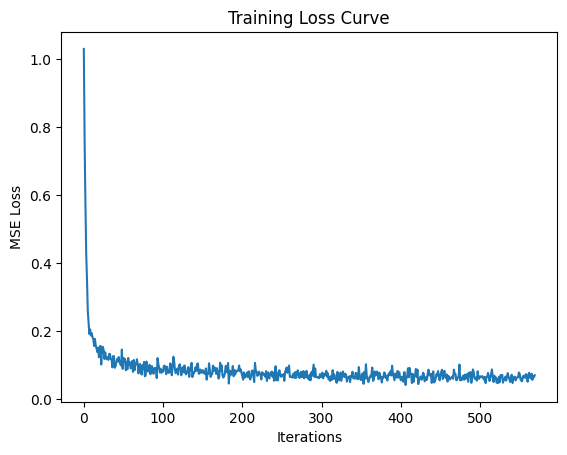

In [32]:
from torch.cuda.amp import GradScaler, autocast

# 数据加载器
train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True)

# Network, loss function, optimizer
net = UnconditionalUnet().to(device)
loss_fn = nn.MSELoss()
# The optimizer
# opt = torch.optim.Adam(net.parameters(), lr=1e-3)
opt = torch.optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)  # AdamW 
# AMP
scaler = torch.amp.GradScaler()  

losses = []
n_epochs = 10
best_loss = float('inf')

# 训练循环
for epoch in range(n_epochs):  # 增加训练轮次
    net.train()
    for x, y in tqdm(train_dataloader):  # 只取图像，不需要标签
        x = x.to(device) * 2 - 1  # 归一化到[-1, 1]
        
        # 噪声调度
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
        
        # 前向传播 - 不再需要类别标签
        pred = net(noisy_x, timesteps)
        loss = loss_fn(pred, noise)
        
        # 反向传播
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
    
    # 每5个epoch保存和采样
    if (epoch + 1) % 5 == 0:
        # torch.save(net.state_dict(), f"uc_ckpts/unconditional_epoch_{epoch+1}.pth")
        
        # 快速采样验证
        with torch.no_grad():
            samples = sample_unconditional(net, num_samples=16, device=device)
            save_image(samples, f"uc_outputs/samples_epoch_{epoch+1}.png")

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

    # 如果当前 loss 更好，就保存
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(net.state_dict(), "uc_ckpts/uc_best_model.pth")
        print(f"Saved new best model at epoch {epoch+1} with loss {avg_loss:.6f}")

plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.show()


In [8]:
!nvidia-smi

Wed Jul  9 02:52:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     Off |   00000000:06:00.0 Off |                    0 |
|  0%   30C    P8             29W /  300W |       4MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 3. Unet2D 采样

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

def visualize_unconditional_samples(model, noise_scheduler, num_samples=16, device="cuda", steps=100, figsize=(12, 12)):
    """
    生成无条件样本并在Notebook中直接可视化
    
    参数:
    model: 训练好的无条件UNet模型
    noise_scheduler: 噪声调度器
    num_samples: 要生成的样本数量
    device: 计算设备 ('cuda' 或 'cpu')
    steps: 采样步数
    figsize: 图像显示大小
    """
    # 创建噪声输入
    x = torch.randn(num_samples, 1, 128, 128).to(device)
    
    # 反向扩散采样循环
    for t in tqdm(noise_scheduler.timesteps[-steps:], desc="Sampling"):
        with torch.no_grad():
            residual = model(x, t)
        x = noise_scheduler.step(residual, t, x).prev_sample
    
    # 后处理到 [0, 1] 范围
    samples = (x.detach().cpu().clip(-1, 1) + 1) / 2
    
    # 转换为网格图像 (num_samples, 1, 64, 64) -> (3, H, W)
    grid = torchvision.utils.make_grid(samples, nrow=int(np.sqrt(num_samples)), pad_value=0.8)
    grid = grid.permute(1, 2, 0).numpy()  # 转换为 (H, W, 3)
    
    # 在Notebook中显示
    plt.figure(figsize=figsize)
    plt.imshow(grid.squeeze(), cmap="gray")  # 使用灰度颜色映射
    plt.axis("off")
    plt.title(f"Unconditional Samples ({steps} steps)", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return samples

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

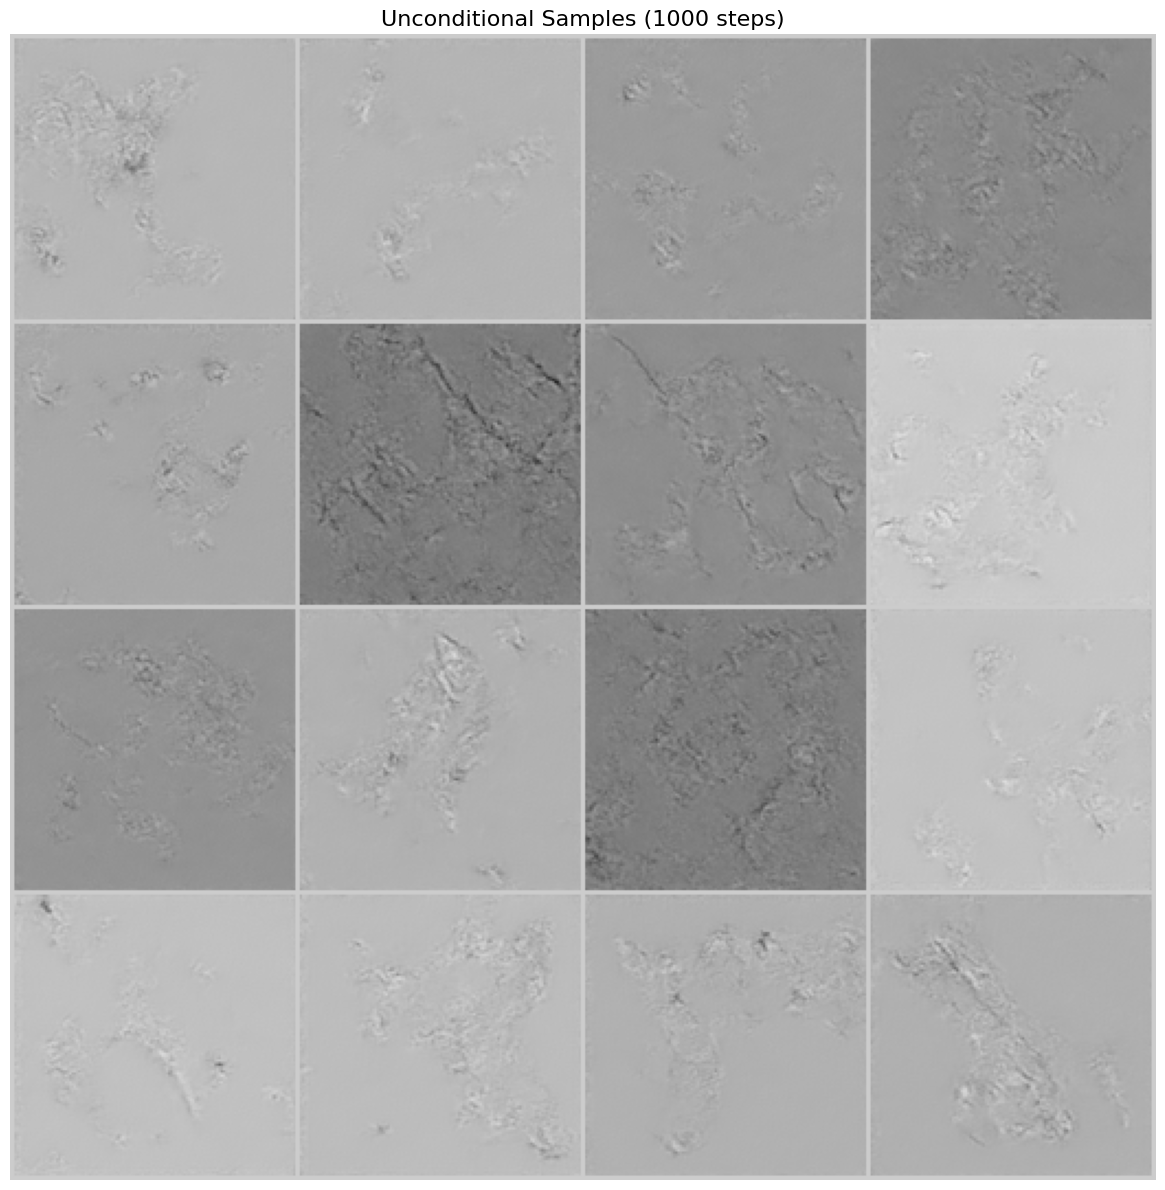

tensor([[[[0.6914, 0.7019, 0.7219,  ..., 0.7184, 0.7097, 0.7425],
          [0.6877, 0.7073, 0.7230,  ..., 0.7131, 0.7025, 0.7274],
          [0.7061, 0.7078, 0.7255,  ..., 0.7182, 0.7123, 0.7147],
          ...,
          [0.7076, 0.7198, 0.7250,  ..., 0.7189, 0.7209, 0.7135],
          [0.7207, 0.7177, 0.7298,  ..., 0.7213, 0.7224, 0.7013],
          [0.7246, 0.7152, 0.7337,  ..., 0.7181, 0.7180, 0.6645]]],


        [[[0.6768, 0.6728, 0.6878,  ..., 0.7172, 0.7060, 0.7301],
          [0.6928, 0.7254, 0.7086,  ..., 0.7023, 0.6855, 0.6996],
          [0.7156, 0.7256, 0.7508,  ..., 0.7245, 0.7080, 0.7124],
          ...,
          [0.7010, 0.6972, 0.7075,  ..., 0.7234, 0.7120, 0.7020],
          [0.7227, 0.7089, 0.7052,  ..., 0.7088, 0.7091, 0.7120],
          [0.7355, 0.7050, 0.6961,  ..., 0.7013, 0.7124, 0.6941]]],


        [[[0.6208, 0.6008, 0.6106,  ..., 0.5996, 0.5812, 0.5544],
          [0.5932, 0.6059, 0.6049,  ..., 0.6188, 0.6093, 0.6025],
          [0.6119, 0.6135, 0.6227,  ..

In [35]:
# 训练后采样并可视化
visualize_unconditional_samples(net, noise_scheduler, num_samples=16, steps=1000)

# DDIM
#visualize_unconditional_samples(net, ddim_scheduler, num_samples=16, steps=50)

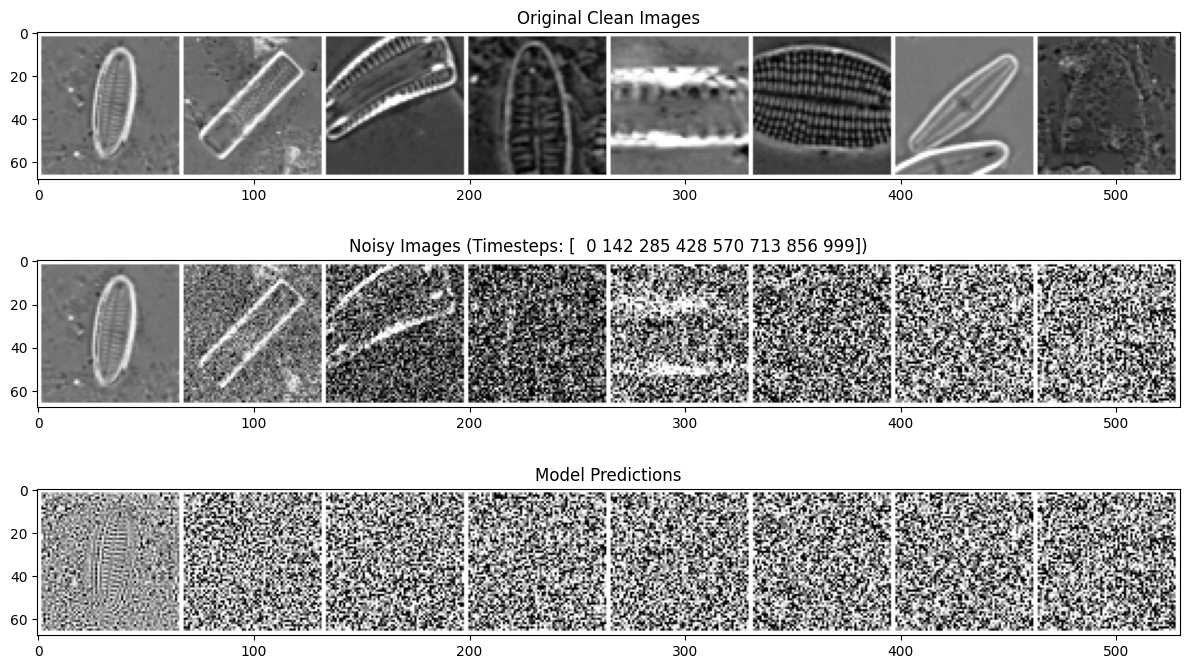

In [36]:
# 获取一些数据
x, y = next(iter(train_loader))
x = x[:8].to(device)  # 取前8个绘图
x = x * 2 - 1  # 归一化到[-1, 1]范围

# 获取噪声调度器的总时间步数
total_timesteps = noise_scheduler.config.num_train_timesteps 

# 创建一组时间步（对应不同的噪声水平）
# 从低噪声(小时间步)到高噪声(大时间步) 
timesteps = torch.linspace(0, total_timesteps - 1, x.shape[0], device=device).long() # 使用标量

# 为每个样本生成随机噪声
noise = torch.randn_like(x)

# 使用噪声调度器添加噪声
noised_x = noise_scheduler.add_noise(x, noise, timesteps)

# 获取模型预测
with torch.no_grad():
    preds = net(noised_x, timesteps).detach().cpu()

# 转换回[0, 1]范围用于显示
def denormalize(tensor):
    """将[-1, 1]范围的张量转换回[0, 1]范围"""
    return (tensor + 1) / 2

x_show = denormalize(x).cpu()
noised_x_show = denormalize(noised_x).cpu()
preds_show = denormalize(preds)

# 绘图
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Original Clean Images")
axs[0].imshow(torchvision.utils.make_grid(x_show)[0].clip(0, 1), cmap="Greys")

axs[1].set_title(f"Noisy Images (Timesteps: {timesteps.cpu().numpy()})")
axs[1].imshow(torchvision.utils.make_grid(noised_x_show)[0].clip(0, 1), cmap="Greys")

axs[2].set_title("Model Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds_show)[0].clip(0, 1), cmap="Greys")

plt.tight_layout()
plt.show()

$ x_0 = \frac{x_t - \sqrt{1 - \bar{\alpha}_t}\epsilon_\theta}{\sqrt{\bar{\alpha}_t}} $ <br>
$ \bar{\alpha}_t = \prod_{s=1}^{t}\alpha_{t \in s} $ <br>
$ \epsilon \sim \mathcal{N}(0, I) $

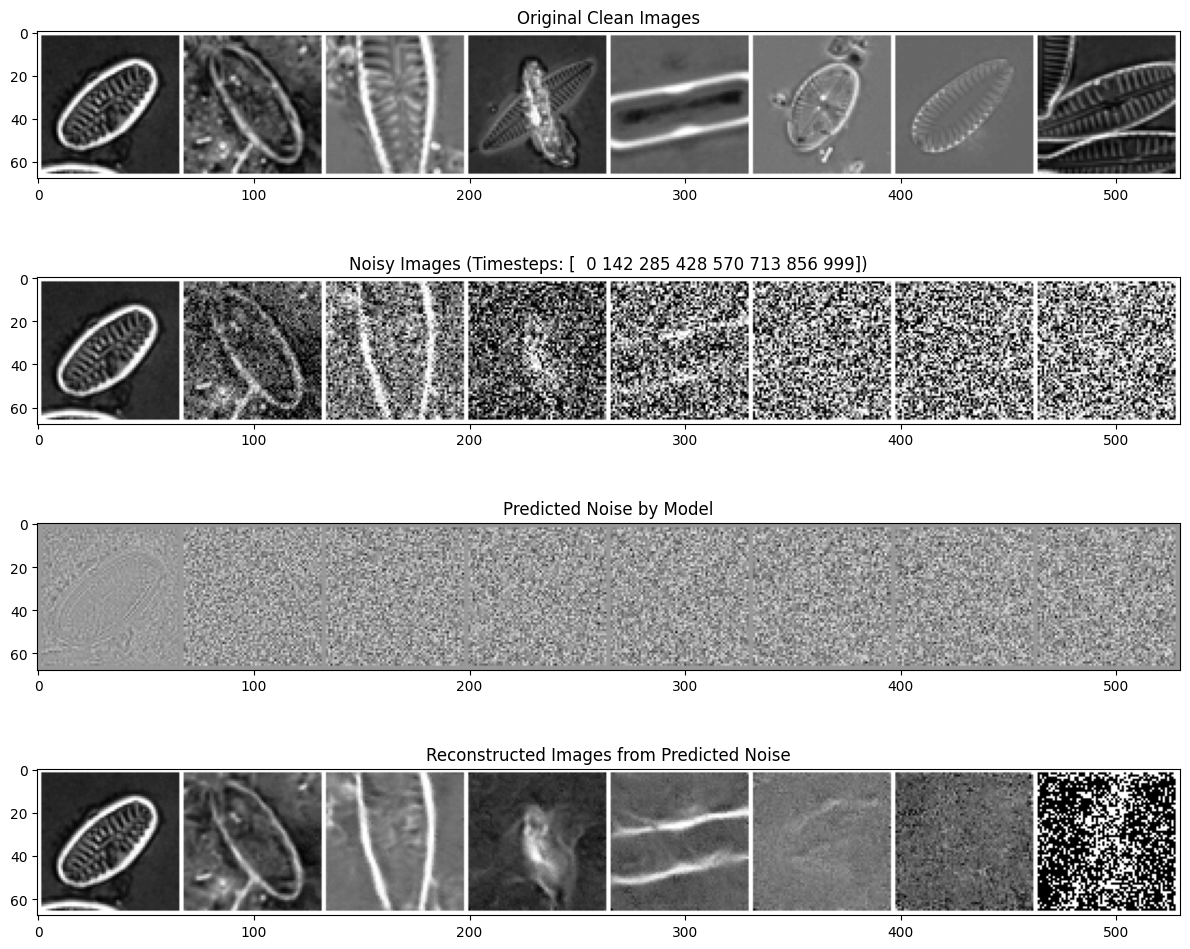

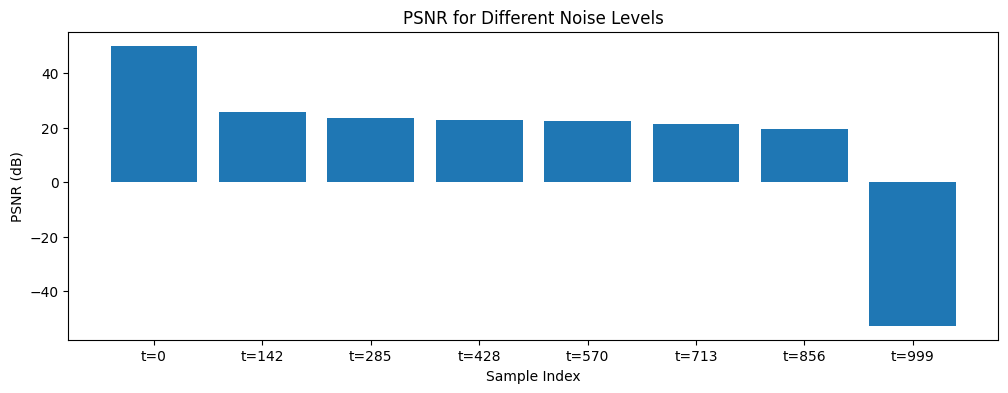

平均PSNR: 16.59 dB


In [47]:
# 获取一些数据
x, y = next(iter(train_loader))
x = x[:8].to(device)  # 取前8个用于绘图
x = x * 2 - 1  # 归一化到[-1, 1]范围

# 获取噪声调度器的总时间步数
total_timesteps = noise_scheduler.config.num_train_timesteps 

# 创建一组时间步（对应不同的噪声水平）
# 从低噪声(小时间步)到高噪声(大时间步) 
timesteps = torch.linspace(0, total_timesteps - 1, x.shape[0], device=device).long()

# 为每个样本生成随机噪声
noise = torch.randn_like(x)

# 使用噪声调度器添加噪声
noised_x = noise_scheduler.add_noise(x, noise, timesteps)

# 获取模型预测
with torch.no_grad():
    # 模型预测的是噪声
    pred_noise = net(noised_x, timesteps)
    
    # 使用预测的噪声重建图像
    # 获取调度器参数
    alphas_cumprod = noise_scheduler.alphas_cumprod[timesteps].view(-1, 1, 1, 1)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)
    
    # 重建公式: x_recon = (noised_x - sqrt_one_minus_alphas_cumprod * pred_noise) / sqrt_alphas_cumprod
    reconstructed_x = (noised_x - sqrt_one_minus_alphas_cumprod * pred_noise) / sqrt_alphas_cumprod

# 转换回[0, 1]范围用于显示
def denormalize(tensor):
    """将[-1, 1]范围的张量转换回[0, 1]范围"""
    return (tensor + 1) / 2

x_show = denormalize(x).cpu()
noised_x_show = denormalize(noised_x).cpu()
reconstructed_x_show = denormalize(reconstructed_x).cpu()
pred_noise_show = pred_noise.cpu()  # 噪声通常不需要归一化

# 绘图
fig, axs = plt.subplots(4, 1, figsize=(12, 10))

# 原始clean图像
axs[0].set_title("Original Clean Images")
axs[0].imshow(torchvision.utils.make_grid(x_show)[0].clip(0, 1), cmap="Greys")

# 带噪声图像（显示时间步）
axs[1].set_title(f"Noisy Images (Timesteps: {timesteps.cpu().numpy()})")
axs[1].imshow(torchvision.utils.make_grid(noised_x_show)[0].clip(0, 1), cmap="Greys")

# 可视化模型预测的噪声
axs[2].set_title("Predicted Noise by Model")
noise_grid = torchvision.utils.make_grid(pred_noise_show)
# 归一化噪声到[0,1]范围
noise_grid = (noise_grid - noise_grid.min()) / (noise_grid.max() - noise_grid.min())
axs[2].imshow(noise_grid[0], cmap="Greys")

# 重建的图像
axs[3].set_title("Reconstructed Images from Predicted Noise")
axs[3].imshow(torchvision.utils.make_grid(reconstructed_x_show)[0].clip(0, 1), cmap="Greys")

plt.tight_layout()
plt.show()

# 可选：计算并显示PSNR指标
def calculate_psnr(original, reconstructed):
    """计算峰值信噪比(PSNR)"""
    mse = torch.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0  # 图像范围[0,1]
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr.item()

# 计算每个样本的PSNR
psnr_values = []
for i in range(len(x)):
    orig = denormalize(x[i]).cpu()
    recon = reconstructed_x_show[i]
    psnr = calculate_psnr(orig, recon)
    psnr_values.append(psnr)

# 在图像上标注PSNR值
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(range(len(psnr_values)), psnr_values)
ax.set_title("PSNR for Different Noise Levels")
ax.set_xlabel("Sample Index")
ax.set_ylabel("PSNR (dB)")
ax.set_xticks(range(len(psnr_values)))
ax.set_xticklabels([f"t={t}" for t in timesteps.cpu().numpy()])
plt.show()

print(f"平均PSNR: {sum(psnr_values)/len(psnr_values):.2f} dB")

## 4. 直接预测图像 训练

In [21]:
# 创建 scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

  0%|          | 0/57 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.041744
Not for now, Saved new best model at epoch 1 with loss 0.041744


  0%|          | 0/57 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.049595


  0%|          | 0/57 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.040492
Not for now, Saved new best model at epoch 3 with loss 0.040492


  0%|          | 0/57 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.037407
Not for now, Saved new best model at epoch 4 with loss 0.037407


  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.036032
Not for now, Saved new best model at epoch 5 with loss 0.036032


  0%|          | 0/57 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.034923
Not for now, Saved new best model at epoch 6 with loss 0.034923


  0%|          | 0/57 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.034299
Not for now, Saved new best model at epoch 7 with loss 0.034299


  0%|          | 0/57 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.035073


  0%|          | 0/57 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.032749
Not for now, Saved new best model at epoch 9 with loss 0.032749


  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.031142
Not for now, Saved new best model at epoch 10 with loss 0.031142


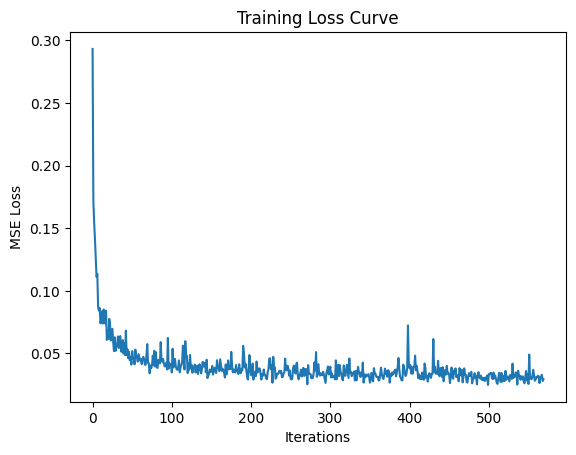

In [19]:
from torch.cuda.amp import GradScaler, autocast

# 数据加载器
train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True)

# Network, loss function, optimizer
net = UnconditionalUnet().to(device)
loss_fn = nn.MSELoss()
# The optimizer
# opt = torch.optim.Adam(net.parameters(), lr=1e-3)
opt = torch.optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)  # AdamW 
# AMP
scaler = torch.amp.GradScaler()  

losses = []
n_epochs = 10
best_loss = float('inf')

# 训练循环
for epoch in range(n_epochs):  # 增加训练轮次
    net.train()
    for x, y in tqdm(train_dataloader):  # 只取图像，不需要标签
        x = x.to(device) * 2 - 1  # 归一化到[-1, 1]
        
        # 噪声调度
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
        
        # 前向传播 - 不再需要类别标签
        pred = net(noisy_x, timesteps)
        loss = loss_fn(pred, x)
        
        # 反向传播
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
    
    # 每5个epoch保存和采样
    if (epoch + 1) % 5 == 0:
        # torch.save(net.state_dict(), f"uc_ckpts/unconditional_epoch_{epoch+1}.pth")
        
        # 快速采样验证
        with torch.no_grad():
            samples = sample_unconditional(net, num_samples=16, device=device)
            # save_image(samples, f"uc_outputs/samples_epoch_{epoch+1}.png")

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

    # 如果当前 loss 更好，就保存
    if avg_loss < best_loss:
        best_loss = avg_loss
        # torch.save(net.state_dict(), "uc_ckpts/uc_best_model.pth")
        print(f"Not for now, Saved new best model at epoch {epoch+1} with loss {avg_loss:.6f}")

plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.show()


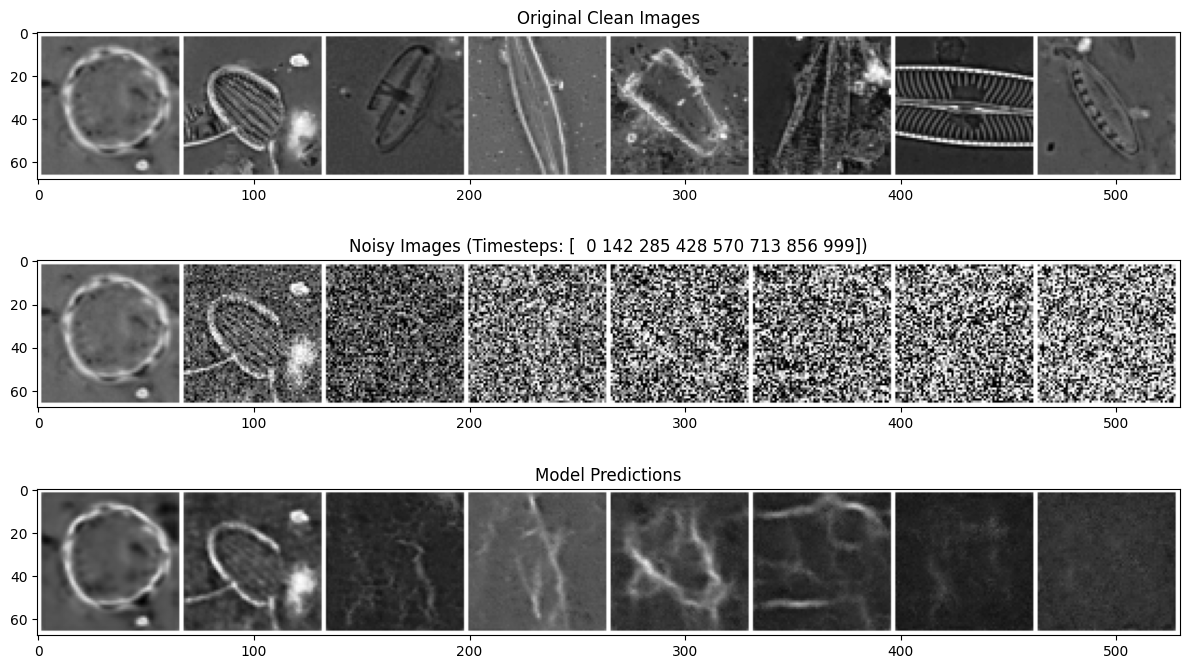

In [30]:
# 获取一些数据
x, y = next(iter(train_loader))
x = x[:8].to(device)  # 只取前8个用于绘图，并移到设备上
x = x * 2 - 1  # 归一化到[-1, 1]范围

# 获取噪声调度器的总时间步数
total_timesteps = noise_scheduler.config.num_train_timesteps  # 对于Hugging Face的调度器
# 或者如果是自定义调度器: total_timesteps = noise_scheduler.num_timesteps

# 创建一组时间步（对应不同的噪声水平）
# 从低噪声(小时间步)到高噪声(大时间步)
# 确保使用标量值而不是张量
timesteps = torch.linspace(0, total_timesteps - 1, x.shape[0], device=device).long()

# 为每个样本生成随机噪声
noise = torch.randn_like(x)

# 使用噪声调度器添加噪声
noised_x = noise_scheduler.add_noise(x, noise, timesteps)

# 获取模型预测
with torch.no_grad():
    # 模型需要两个输入：带噪图像和时间步
    preds = net(noised_x, timesteps).detach().cpu()

# 转换回[0, 1]范围用于显示
def denormalize(tensor):
    """将[-1, 1]范围的张量转换回[0, 1]范围"""
    return (tensor + 1) / 2

x_show = denormalize(x).cpu()
noised_x_show = denormalize(noised_x).cpu()
preds_show = denormalize(preds)

# 绘图
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Original Clean Images")
axs[0].imshow(torchvision.utils.make_grid(x_show)[0].clip(0, 1), cmap="Greys")

axs[1].set_title(f"Noisy Images (Timesteps: {timesteps.cpu().numpy()})")
axs[1].imshow(torchvision.utils.make_grid(noised_x_show)[0].clip(0, 1), cmap="Greys")

axs[2].set_title("Model Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds_show)[0].clip(0, 1), cmap="Greys")

plt.tight_layout()
plt.show()